In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import umap
import time
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

### Load the abundance

In [6]:
abundance_maps = (np.load('../../../../primary_data/abundance_maps.npz')['arr_0'])/255
print(abundance_maps.shape)

# select the abundance maps to be considered
indices = [3,4,6,1,9,7]
colors = [[1,0,0], [0,1,0], [0,0,1], [0,1,1], [1,0,1], [1,1,0]]

abundance_maps = abundance_maps[indices,:,:,:]
print(abundance_maps.shape)

(11, 1024, 1024, 30)
(6, 1024, 1024, 30)


### load the data folder

In [14]:
spectrum_folder = '../../../../primary_data/main_mosaic_6by5/Spectrum2D_PC10/'
file_names = []
tmp = os.listdir(spectrum_folder)
for filename in tmp:
    if filename.endswith('.npz'):
        file_names.append(filename)

file_names = sorted(file_names)
files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]


### subsample from all the tiles the spectrum 2D 

In [52]:
subsample_size = int(0.1*1024**2)
np.random.rand(100); sample = np.random.choice(1024**2, subsample_size)

spectrum_2D = np.zeros((subsample_size*abundance_maps.shape[3],250))

for tile_idx in range(abundance_maps.shape[3]):
    # data
    spectrum_2D[tile_idx*subsample_size:(tile_idx+1)*subsample_size,:] =  np.load(files[tile_idx])['spectrum_2D'][sample,:]
    print(tile_idx,end='\r')

### get the corresponding RGBA colors

In [53]:
colors_list = np.zeros((subsample_size*abundance_maps.shape[3],4))   #RGBA

for tile_idx in range(abundance_maps.shape[3]):
    # color
    max_color_tile = np.argmax(abundance_maps_selected[:,:,:,tile_idx],axis=0)
    alpha_tile = np.max(abundance_maps_selected[:,:,:,tile_idx],axis=0)
    
    # reshape
    max_color_tile = max_color_tile.reshape((1024**2))
    alpha_tile = alpha_tile.reshape(((1024**2)))
    
    # set RGB then A
    colors_list[tile_idx*subsample_size:(tile_idx+1)*subsample_size,0:3] = [colors[i] for i in max_color_tile[sample]]
    colors_list[tile_idx*subsample_size:(tile_idx+1)*subsample_size,3] = [alpha_tile[i] for i in max_color_tile[sample]]
    

### Apply umap

In [54]:
# Apply UMAP directly
start = datetime.now()
umap_metric = 'chevyshev'
umap1 = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.0, metric=umap_metric,random_state=100)
embeddings = umap1.fit_transform(spectrum_2D)

end = datetime.now()
# if 3 dimensions for UMAP, which ones to use (0,1,or 2)
dim_a = 0
dim_b = 1

# scaling
scaler = MinMaxScaler()
embeddings = scaler.fit_transform(embeddings)

etime = end-start
print('Duration for UMAP fitting: {}'.format(end - start))

/Users/aj/Desktop/work/virtualenvs/edx/lib/python3.9/site-packages/umap/spectral.py:342: UserWarning: Exited at iteration 20 with accuracies 
[0.01766255 0.01928215 0.0239461 ]
not reaching the requested tolerance 1e-08.
  eigenvalues, eigenvectors = scipy.sparse.linalg.lobpcg(


Duration for UMAP fitting: 0:18:28.790343


### Visualize

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


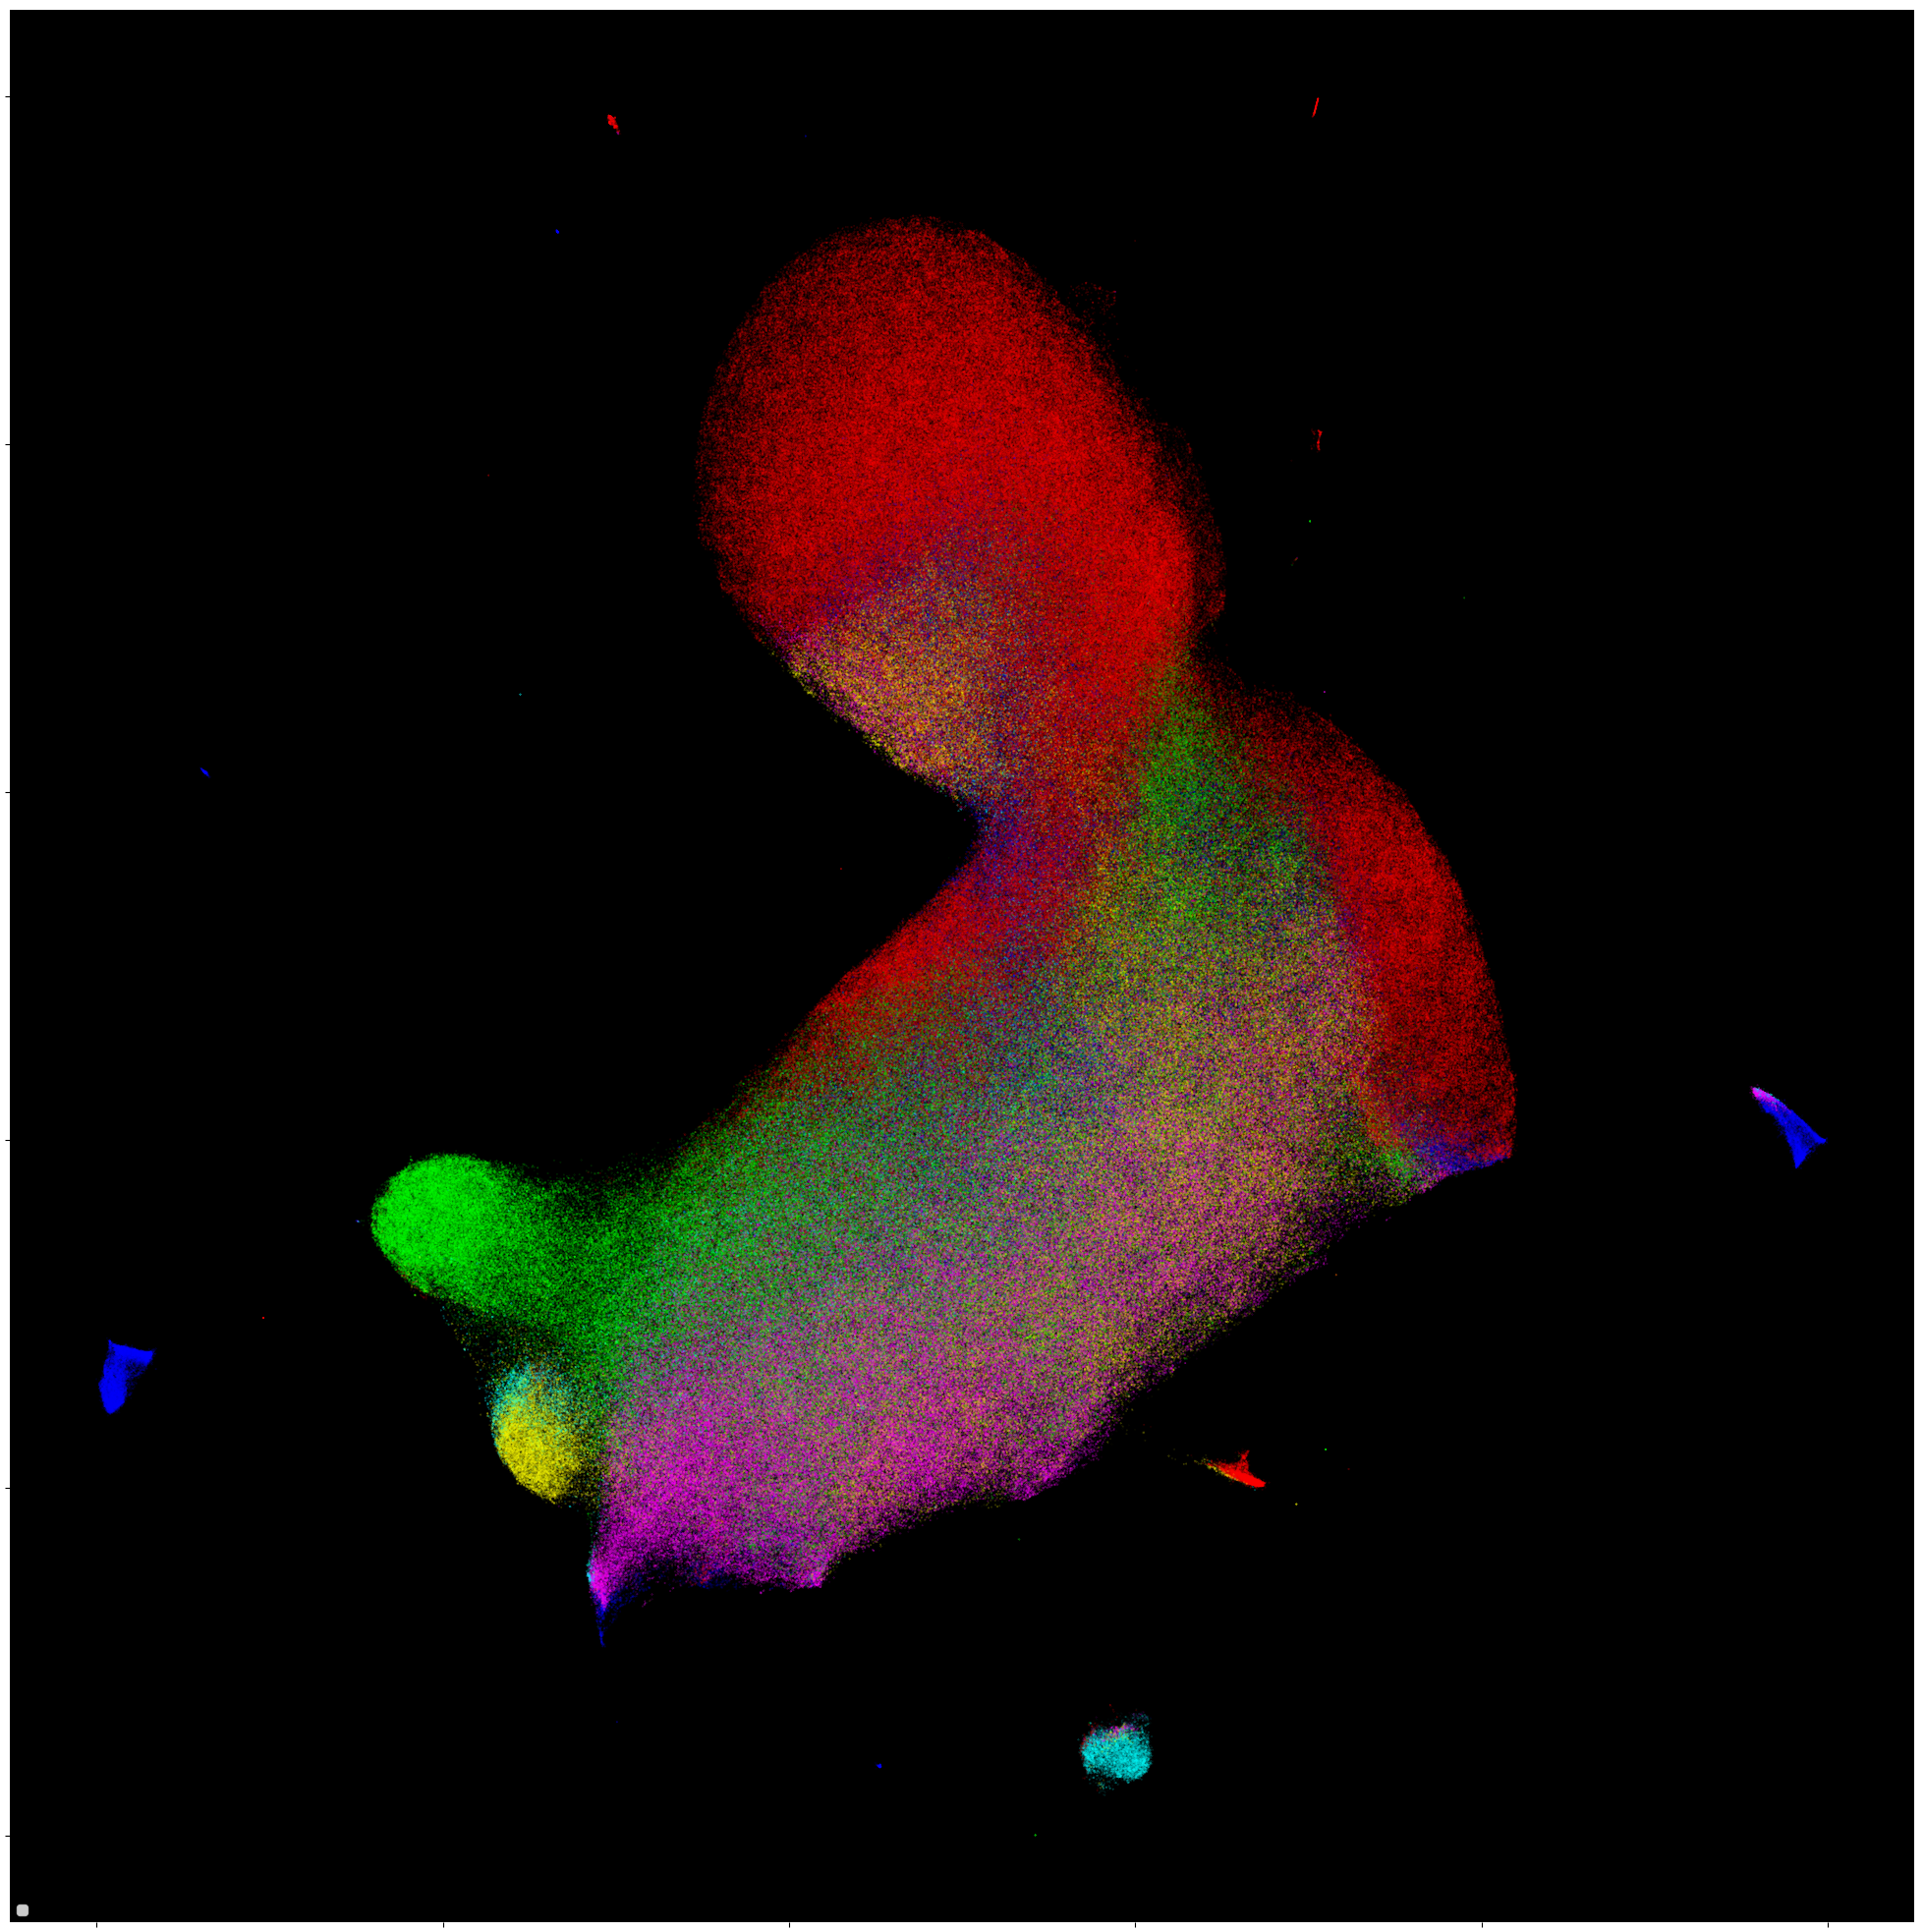

In [82]:
%matplotlib inline 

f, ax = plt.subplots(figsize=(20,20))
sns.despine(left=True, bottom=True, right=True)
ax.set_facecolor("black")
ax.scatter(embeddings[:,dim_a],embeddings[:,dim_b], s=0.05,c=colors_list,marker='o') 
f.tight_layout() 

#plt.axis('off')
#plt.show()

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

plt.legend(loc=3)
plt.savefig('../../../../primary_data/other_png/Figure_6_%s.png' % umap_metric,dpi=300)